# Spoint tutorial: Deconvolution of cell types composition on human brain Visium dataset

July 2023

Dataset: Visium slices of human dorsolateral prefrontal cortex ([here](https://zenodo.org/record/8167488)).

In [1]:
from KanCell.setting import set_environ_seed
set_environ_seed()
from KanCell import Spoint
import scanpy as sc
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

Setting environment seed: 42


Global seed set to 0


## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in `.obs`.

In [4]:
sc_ad = sc.read_h5ad('/data/KanCell-main/docs/data/mouse hippocampous/sc_adata.h5ad')
st_ad = sc.read_h5ad('/data/KanCell-main/docs/data/mouse hippocampous/spatial.h5ad')

sc.pp.filter_genes(st_ad,min_cells=1)
sc.pp.filter_genes(sc_ad,min_cells=1)
sc.pp.filter_cells(st_ad,min_genes=1)
sc.pp.filter_cells(sc_ad,min_genes=1)

In [ ]:
sc_ad

AnnData object with n_obs × n_vars = 23372 × 20420
    obs: 'CellType', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
st_ad

AnnData object with n_obs × n_vars = 4656 × 20420
    obs: 'n_genes'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'

## Initialize the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The `celltype_key` parameter represents the column name of the cell type annotation in the `.obs` attribute of the scRNA-seq anndata object. The `sm_size` parameter controls the number of simulated spots, and it is important to have a sufficient `sm_size` for accurate prediction. However, it should be noted that increasing the `sm_size` will also increase the simulation and training time. In general, we recommend setting `sm_size` to a value greater than 100,000.

In [ ]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
spoint_model = Spoint.init_model(sc_ad,st_ad,celltype_key='CellType',deg_method='t-test',sm_size=100000,use_gpu=True)

Setting global seed: 42


normalizing counts per cell
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
### Finding marker genes...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:03)
CellType
TYPE_Astrocyte          200
TYPE_CA1                200
TYPE_Cajal Retzius      200
TYPE_Choroid            200
TYPE_Dentate            200
TYPE_Entorhinal         200
TYPE_Endothelial        200
TYPE_Ependyma           200
TYPE_Fibroblast         200
TYPE_Sic17ab            200
TYPE_Gad2               200
TYPE_Microglia          200
TYPE_Oligodendrocyte    200
TYPE_Polydendrocyte     200
TYPE_CA2CA3             194
TYPE_Neurogenesis        88
TYPE_Mural               76
N

## Training the Spoint model

Here, we train the model to obtain the optimal model for cell type deconvolution. The `max_steps` parameter represents the maximum number of steps in the training process. If the `early_stop` parameter is set to `True`, the model will stop training before reaching the maximum number of steps if the model has converged.

In [ ]:

import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
spoint_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:06<10:11,  6.17s/it, loss=4.59e+03, v_num=1]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/100:   7%|▋         | 7/100 [00:19<03:36,  2.33s/it, loss=4.04e+03, v_num=1]

Epoch 100/100: 100%|██████████| 100/100 [03:42<00:00,  2.18s/it, loss=3.71e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it, loss=3.71e+03, v_num=1]


Step 5000: Test inference loss=-0.818: 100%|██████████| 5000/5000 [34:28<00:00,  2.42it/s]


## Visualization results

Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a `DataFrame` object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the `.obs` attribute.

In [ ]:
pre = spoint_model.deconv_spatial()

In [ ]:
st_ad = spoint_model.st_ad

We can see the result of deconvolution in the ST slice.

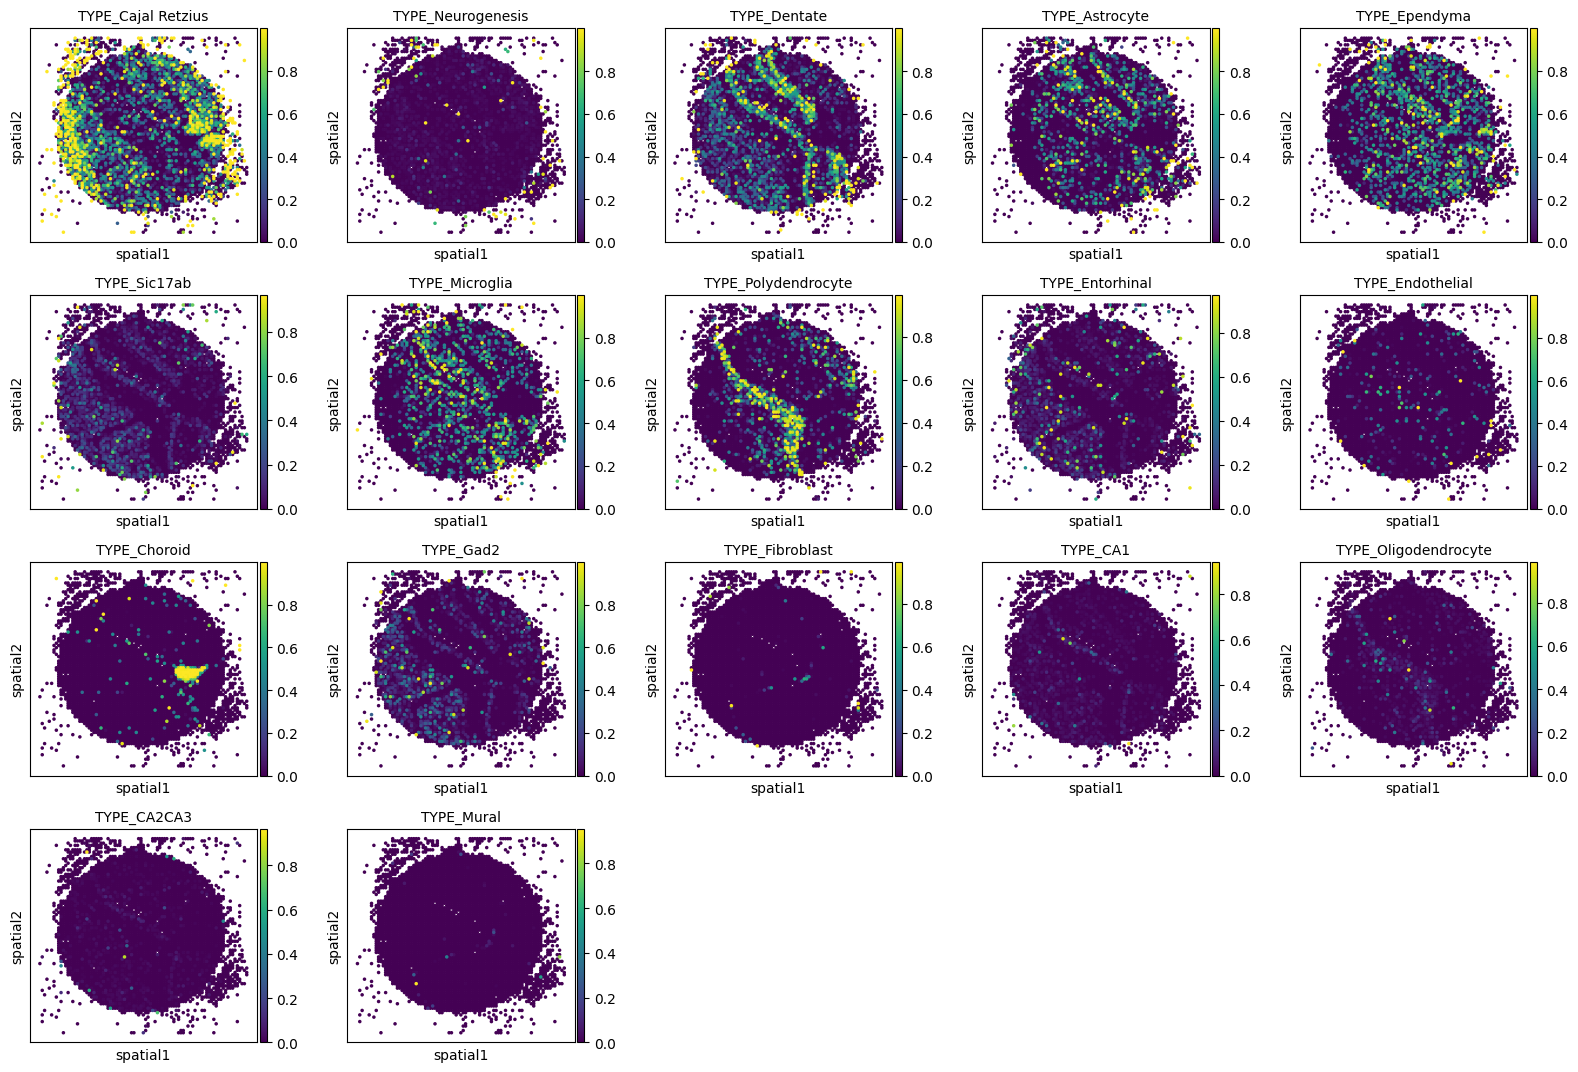

In [ ]:
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5)

In [ ]:
st_ad

AnnData object with n_obs × n_vars = 4656 × 2175
    obs: 'n_genes', 'batch', 'TYPE_Cajal Retzius', 'TYPE_Neurogenesis', 'TYPE_Dentate', 'TYPE_Astrocyte', 'TYPE_Ependyma', 'TYPE_Sic17ab', 'TYPE_Microglia', 'TYPE_Polydendrocyte', 'TYPE_Entorhinal', 'TYPE_Endothelial', 'TYPE_Choroid', 'TYPE_Gad2', 'TYPE_Fibroblast', 'TYPE_CA1', 'TYPE_Oligodendrocyte', 'TYPE_CA2CA3', 'TYPE_Mural'
    var: 'n_cells'
    uns: 'log1p', 'celltypes'
    obsm: 'spatial'
    layers: 'norm'

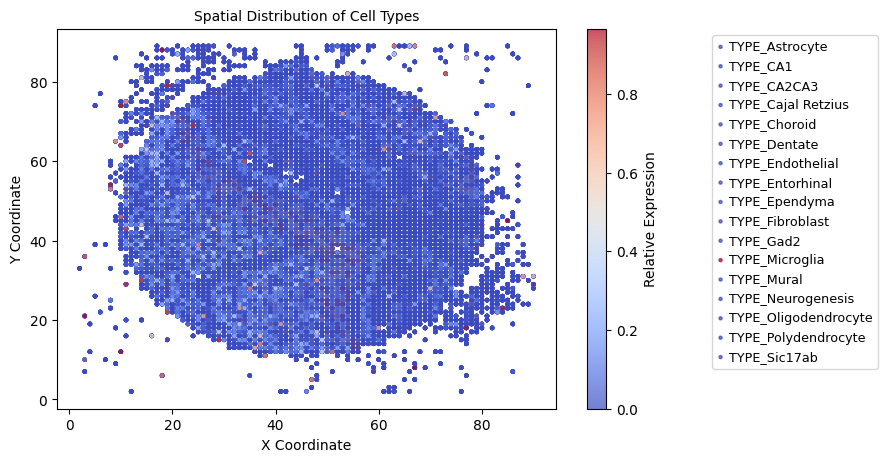

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 提取坐标信息
spatial_coords = st_ad.obsm['spatial']

# 设置画布大小
plt.figure(figsize=(8, 5))

# 遍历每个细胞类型
for cell_type in ['TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 
                  'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Endothelial', 'TYPE_Entorhinal', 
                  'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 
                  'TYPE_Mural', 'TYPE_Neurogenesis', 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 
                  'TYPE_Sic17ab']:
    # 获取细胞类型的相对表达量
    expression = st_ad.obs[cell_type]
    
    # 绘制每个细胞类型的表达量
    plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=expression, cmap='coolwarm', alpha=0.7, label=cell_type, s=5)

# 添加颜色条
plt.colorbar(label='Relative Expression')

# 添加标题和轴标签
plt.title('Spatial Distribution of Cell Types')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 设置Seaborn调色板
palette = sns.color_palette("husl", len(['TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 
                  'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Endothelial', 'TYPE_Entorhinal', 
                  'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 
                  'TYPE_Mural', 'TYPE_Neurogenesis', 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 
                  'TYPE_Sic17ab']))
sns.set_palette(palette)

# 将图例放在外面
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
# 去掉网格
plt.grid(False)
# 显示图形
plt.show()


In [ ]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
from sklearn.metrics import mean_squared_error
rcParams['pdf.fonttype'] = 42


In [ ]:
import pandas as pd

# 读取ground_truth.csv文件
ground_truth = pd.read_csv('/data/Celloc-main/data/Hippocampus/5/ground_truth.csv')

# 按'SpotID'和'CellType'分组，计算每个点中每种细胞类型的数量
grouped_data = ground_truth.groupby(['SpotID', 'CellType']).size().reset_index(name='Count')

# 透视表：每行对应一个点，每列代表细胞类型，每个条目表示该点中特定细胞类型的数量
ground_truth_pivot = grouped_data.pivot(index='SpotID', columns='CellType', values='Count')

# 计算比例，将缺失值填充为0
ground_truth_pivot = ground_truth_pivot.div(ground_truth_pivot.sum(axis=1), axis=0).fillna(0)

# 打印查看生成的DataFrame对象
print(ground_truth_pivot.head())

CellType  Astrocyte  CA1  CA2CA3  Cajal Retzius  Choroid  Dentate  \
SpotID                                                              
S1              0.0  0.0    0.00       0.000000      0.0     0.00   
S10             0.0  0.0    0.00       1.000000      0.0     0.00   
S100            0.0  0.0    0.25       0.000000      0.0     0.25   
S1000           0.0  0.0    0.00       0.000000      0.0     0.00   
S1001           0.0  0.0    0.00       0.333333      0.0     0.00   

CellType  Endothelial  Entorhinal  Ependyma  Fibroblast  Gad2  Microglia  \
SpotID                                                                     
S1                0.0         0.0  0.000000         0.0   0.0        1.0   
S10               0.0         0.0  0.000000         0.0   0.0        0.0   
S100              0.0         0.0  0.000000         0.0   0.0        0.0   
S1000             0.0         0.0  0.000000         0.0   0.0        1.0   
S1001             0.0         0.0  0.333333         0.0   0.

In [ ]:
# 将 ground_truth_pivot 的 SpotID 格式与 st_ad 的 SpotID 格式匹配
ground_truth_pivot.index = 'SPOT_' + ground_truth_pivot.index
ground_truth_pivot



CellType,Astrocyte,CA1,CA2CA3,Cajal Retzius,Choroid,Dentate,Endothelial,Entorhinal,Ependyma,Fibroblast,Gad2,Microglia,Mural,Neurogenesis,Oligodendrocyte,Polydendrocyte,Sic17ab
SpotID,,,,,,,,,,,,,,,,,
SPOT_S1,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0
SPOT_S10,0.0,0.0,0.00,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
SPOT_S100,0.0,0.0,0.25,0.000000,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.5
SPOT_S1000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0
SPOT_S1001,0.0,0.0,0.00,0.333333,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPOT_S995,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0
SPOT_S996,0.0,0.0,0.00,0.000000,0.0,0.400000,0.0,0.0,0.200000,0.0,0.0,0.200000,0.0,0.200000,0.0,0.000000,0.0
SPOT_S997,0.0,0.0,0.00,0.000000,0.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.0


In [ ]:


# 提取 SpotID 中的数字部分
spot_numbers = ground_truth_pivot.index.str.extract(r'(\d+)').astype(int)

# 将 DataFrame 按照提取的数字部分进行排序
ground_truth_pivot = ground_truth_pivot.iloc[spot_numbers[0].argsort().values]

ground_truth_pivot
# ground_truth_pivot.to_csv('/data/Celloc-main/data/Hippocampus/15/results/ground_truth.csv', index=False,float_format='%.6f')

CellType,Astrocyte,CA1,CA2CA3,Cajal Retzius,Choroid,Dentate,Endothelial,Entorhinal,Ependyma,Fibroblast,Gad2,Microglia,Mural,Neurogenesis,Oligodendrocyte,Polydendrocyte,Sic17ab
SpotID,,,,,,,,,,,,,,,,,
SPOT_S1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
SPOT_S2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SPOT_S3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.0
SPOT_S4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
SPOT_S5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPOT_S4652,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SPOT_S4653,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SPOT_S4654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd

# 假设你要选择的列名为 'TYPE_Astrocyte', 'TYPE_Bergmann', 'TYPE_Choroid' 等
selected_columns = ['TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 'TYPE_Choroid', 'TYPE_Dentate', 
'TYPE_Endothelial', 'TYPE_Entorhinal', 'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 'TYPE_Mural', 'TYPE_Neurogenesis',
 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 'TYPE_Sic17ab']

# 从 adata.obs 中选择指定的列，并重命名列名
selected_data = st_ad.obs[selected_columns].rename(columns={
    'TYPE_Astrocyte': 'Astrocyte',
    'TYPE_CA1': 'CA1',
    'TYPE_CA2CA3': 'CA2CA3',
    'TYPE_Cajal Retzius': 'Cajal Retzius',
    'TYPE_Choroid': 'Choroid',
    'TYPE_Dentate': 'Dentate',
    'TYPE_Endothelial': 'Endothelial',
    'TYPE_Entorhinal': 'Entorhinal',
    'TYPE_Ependyma': 'Ependyma',
    'TYPE_Fibroblast': 'Fibroblast',
    'TYPE_Gad2': 'Gad2',
    'TYPE_Microglia': 'Microglia',
    'TYPE_Mural': 'Mural',
    'TYPE_Neurogenesis': 'Neurogenesis',
    'TYPE_Oligodendrocyte': 'Oligodendrocyte',
    'TYPE_Polydendrocyte': 'Polydendrocyte',
    'TYPE_Sic17ab': 'Sic17ab'
})

# 重置索引，以 "SpotID" 作为新的索引列
selected_data = selected_data.reset_index()
# 将 'index' 列重命名为 'CellType'
selected_data.rename(columns={'index': 'CellType'}, inplace=True)
# 将 'CellType' 列设置为索引
selected_data.set_index('CellType', inplace=True)
# 为新的索引列设置名称
selected_data.index.name = 'SpotID'

selected_data
# selected_data.to_csv('/data/GraphST-main/Data/simulated/hippocampus/selected_data.csv', index=False, float_format='%.6f')


,Astrocyte,CA1,CA2CA3,Cajal Retzius,Choroid,Dentate,Endothelial,Entorhinal,Ependyma,Fibroblast,Gad2,Microglia,Mural,Neurogenesis,Oligodendrocyte,Polydendrocyte,Sic17ab
SpotID,,,,,,,,,,,,,,,,,
SPOT_S1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.997100,0.0,0.0,0.000000,0.00000,0.000000
SPOT_S2,0.0,0.000000,0.000000,0.999361,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
SPOT_S3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.251148,0.72061,0.000000
SPOT_S4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.039158,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.956549
SPOT_S5,0.0,0.035408,0.045179,0.000000,0.0,0.0,0.0,0.074443,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.844198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPOT_S4652,0.0,0.000000,0.000000,0.997383,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
SPOT_S4653,0.0,0.000000,0.000000,0.999201,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
SPOT_S4654,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.501024,0.0,0.000000,0.490276,0.0,0.0,0.000000,0.00000,0.000000


In [ ]:
# 将 ground_truth_pivot 添加到 st_ad.obs
st_ad.obs = st_ad.obs.merge(ground_truth_pivot, left_index=True, right_index=True, how='left')
selected_data.to_csv('/data/Celloc-main/data/Hippocampus/15/10/results/spacel.csv', index=False,float_format='%.6f')

In [ ]:
st_ad

AnnData object with n_obs × n_vars = 4656 × 2175
    obs: 'n_genes', 'batch', 'TYPE_Cajal Retzius', 'TYPE_Neurogenesis', 'TYPE_Dentate', 'TYPE_Astrocyte', 'TYPE_Ependyma', 'TYPE_Sic17ab', 'TYPE_Microglia', 'TYPE_Polydendrocyte', 'TYPE_Entorhinal', 'TYPE_Endothelial', 'TYPE_Choroid', 'TYPE_Gad2', 'TYPE_Fibroblast', 'TYPE_CA1', 'TYPE_Oligodendrocyte', 'TYPE_CA2CA3', 'TYPE_Mural', 'Astrocyte', 'CA1', 'CA2CA3', 'Cajal Retzius', 'Choroid', 'Dentate', 'Endothelial', 'Entorhinal', 'Ependyma', 'Fibroblast', 'Gad2', 'Microglia', 'Mural', 'Neurogenesis', 'Oligodendrocyte', 'Polydendrocyte', 'Sic17ab'
    var: 'n_cells'
    uns: 'log1p', 'celltypes'
    obsm: 'spatial'
    layers: 'norm'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
with mpl.rc_context({'axes.facecolor':  'white',
                      'figure.figsize': [4.5,4.5]}):
                          # 创建图像对象
                          # 设置背景颜色为白色

                          # 运行函数
                          sc.pl.embedding(st_ad, color=['Astrocyte_x', 'CA1_x',  'Choroid_x', 'Dentate_x', 'Polydendrocyte_x','TYPE_Astrocyte', 'TYPE_CA1',  'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Polydendrocyte'], basis='spatial', ncols=5, size=50)

                          plt.show()


KeyError: 'Could not find key Astrocyte_x in .var_names or .obs.columns.'

<Figure size 1335x450 with 0 Axes>

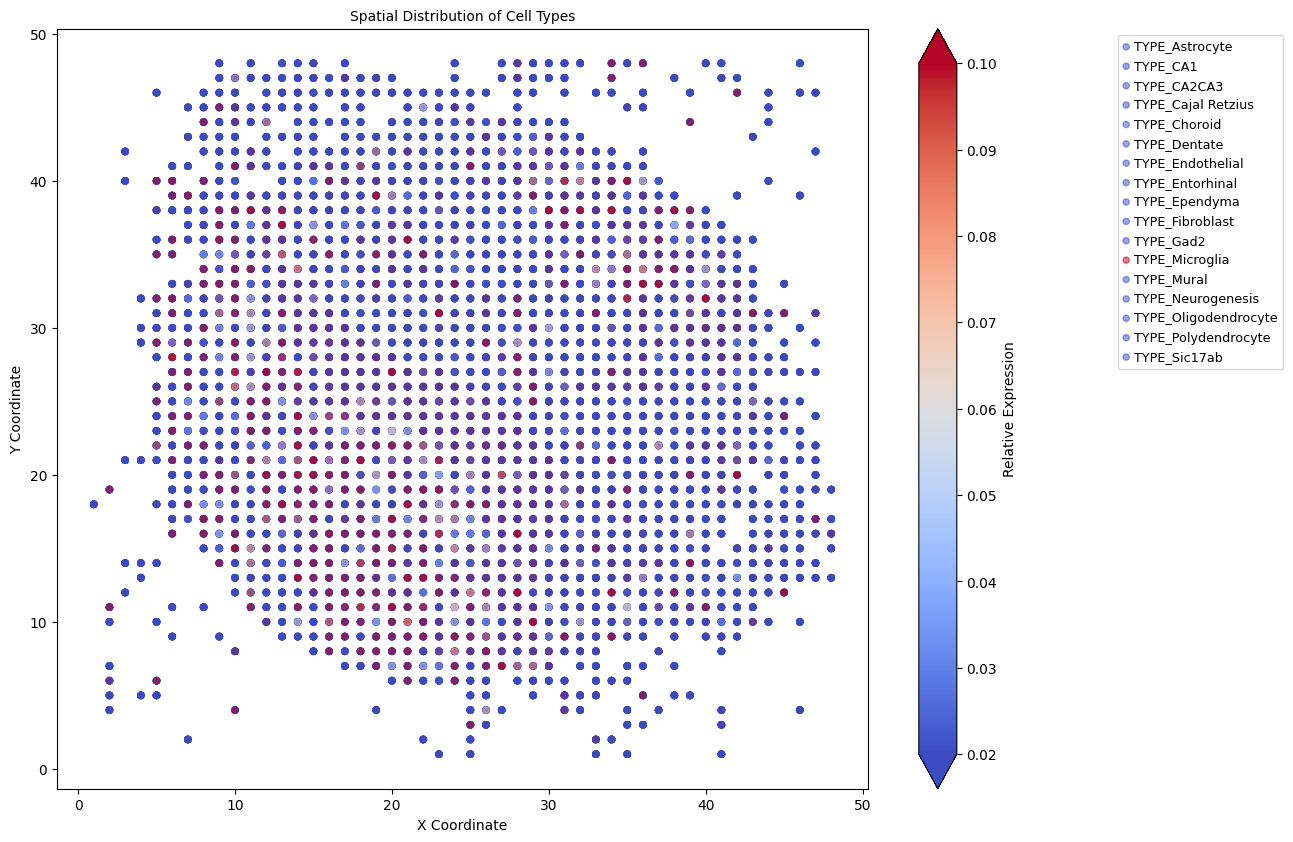

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# 提取坐标信息
spatial_coords = st_ad.obsm['spatial']

# 设置画布大小
fig, ax = plt.subplots(figsize=(13, 10))

# 细胞类型列表
cell_types = [
    'TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 
    'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Endothelial', 'TYPE_Entorhinal', 
    'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 
    'TYPE_Mural', 'TYPE_Neurogenesis', 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 
    'TYPE_Sic17ab'
]

# 创建一个归一化对象用于颜色条
norm = mcolors.Normalize(vmin=0.02, vmax=0.1)

# 遍历每个细胞类型
for cell_type in cell_types:
    # 获取细胞类型的相对表达量
    expression = st_ad.obs[cell_type]
    
    # 绘制每个细胞类型的表达量
    scatter = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=expression, cmap='coolwarm', alpha=0.5, label=cell_type, s=20, norm=norm)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Relative Expression', extend='both')

# 添加标题和轴标签
ax.set_title('Spatial Distribution of Cell Types')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# 设置Seaborn调色板
palette = sns.color_palette("husl", len(['TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 
                  'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Endothelial', 'TYPE_Entorhinal', 
                  'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 
                  'TYPE_Mural', 'TYPE_Neurogenesis', 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 
                  'TYPE_Sic17ab']))
sns.set_palette(palette)
# 将图例放在外面
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left')

# 去掉网格
ax.grid(False)

# 显示图形
plt.show()


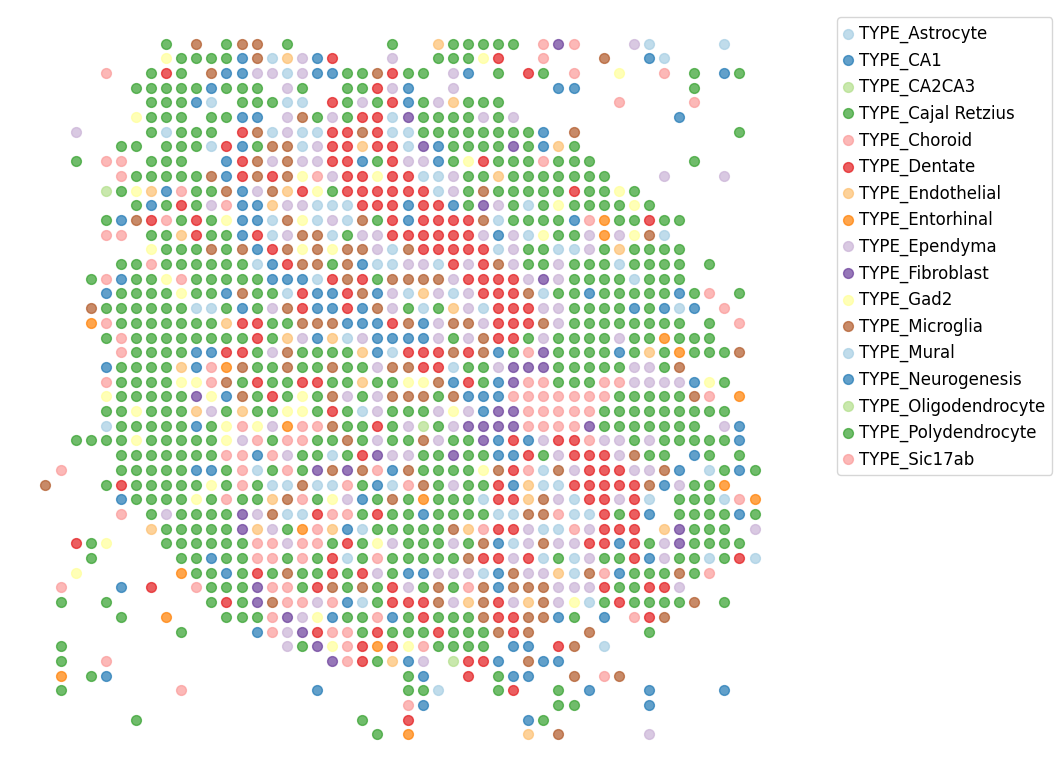

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 提取坐标信息
spatial_coords = st_ad.obsm['spatial']

# 细胞类型列表
cell_types = [
    'TYPE_Astrocyte', 'TYPE_CA1', 'TYPE_CA2CA3', 'TYPE_Cajal Retzius', 
    'TYPE_Choroid', 'TYPE_Dentate', 'TYPE_Endothelial', 'TYPE_Entorhinal', 
    'TYPE_Ependyma', 'TYPE_Fibroblast', 'TYPE_Gad2', 'TYPE_Microglia', 
    'TYPE_Mural', 'TYPE_Neurogenesis', 'TYPE_Oligodendrocyte', 'TYPE_Polydendrocyte', 
    'TYPE_Sic17ab'
]

# 提取每个细胞类型的表达量矩阵
expression_matrix = st_ad.obs[cell_types].values

# 找出每个点的最高表达量的细胞类型
max_expression_indices = np.argmax(expression_matrix, axis=1)

# 创建一个包含每个点的最高表达量细胞类型的列表
max_expression_cell_types = np.array(cell_types)[max_expression_indices]

# 设置更高对比度的颜色调色板
palette = sns.color_palette("Paired", len(cell_types))
color_dict = {cell_type: palette[i] for i, cell_type in enumerate(cell_types)}

# 设置画布大小
plt.figure(figsize=(10, 10))

# 遍历每个细胞类型并绘制其空间分布
for cell_type in cell_types:
    # 获取该细胞类型的点的掩码
    cell_mask = (max_expression_cell_types == cell_type)
    
    # 绘制每个细胞类型的点
    plt.scatter(spatial_coords[cell_mask, 0], spatial_coords[cell_mask, 1], 
                color=color_dict[cell_type], label=cell_type, s=50, alpha=0.7)

# 添加标题
# plt.title('Spatial Distribution of Dominant Cell Types', fontsize=22)

# 去掉图的边框和刻度
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# 去掉 x 和 y 轴的刻度和刻度标签
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

# 将图例放在外面
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 去掉网格
plt.grid(False)

# 显示图形
plt.show()


In [ ]:
cell2loc_results=selected_data
gd_results=ground_truth_pivot

cell2loc_results = (cell2loc_results.T/cell2loc_results.sum(axis=1)).T
cell2loc_results = cell2loc_results.fillna(0)

gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)

gd_results = gd_results.loc[:,np.unique(gd_results.columns)]

In [ ]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df

In [ ]:
#from scipy.stats import jensenshannon

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df
starmap_spots_pcc = compare_results(
    gd_results,
    [cell2loc_results],
    columns = ['Cell2location'],
    axis=0,
    metric='pcc'
)
# starmap_clusters_pcc = compare_results(
#     gd_results,
#     [RCTD_results,cell2loc_results,tangram_results,seurat_results,stereo_results,spotlight_results,spatialdwls_results,destvi_results,dstg_results,stride_results,spa_results,novo_results],
#     columns = ['RCTD','Cell2location','Tangram','Seurat','Stereoscope','SPOTlight','SpatialDWLS','DestVI','DSTG','STRIDE','SpaOTsc','NovoSparc'],
#     axis=1,
#     metric='pcc'
# )
starmap_spots_ssim = compare_results(
    gd_results,
    [cell2loc_results],
    columns = ['Cell2location'],
    axis=0,
    metric='ssim'
)
# starmap_clusters_ssim = compare_results(
#     gd_results,
#     [RCTD_results,cell2loc_results,tangram_results,seurat_results,stereo_results,spotlight_results,spatialdwls_results,destvi_results,dstg_results,stride_results,spa_results,novo_results],
#     columns = ['RCTD','Cell2location','Tangram','Seurat','Stereoscope','SPOTlight','SpatialDWLS','DestVI','DSTG','STRIDE','SpaOTsc','NovoSparc'],
#     axis=1,
#     metric='ssim'
# )
starmap_spots_rmse = compare_results(
    gd_results,
    [cell2loc_results],
    columns = ['Cell2location'],
    axis=0,
    metric='rmse'
)
# starmap_clusters_rmse = compare_results(
#     gd_results,
#     [RCTD_results,cell2loc_results,tangram_results,seurat_results,stereo_results,spotlight_results,spatialdwls_results,destvi_results,dstg_results,stride_results,spa_results,novo_results],
#     columns = ['RCTD','Cell2location','Tangram','Seurat','Stereoscope','SPOTlight','SpatialDWLS','DestVI','DSTG','STRIDE','SpaOTsc','NovoSparc'],
#     axis=1,
#     metric='rmse'
# )
starmap_spots_jsd = compare_results(
    gd_results,
    [cell2loc_results],
    columns = ['Cell2location'],
    axis=0,
    metric='jsd'
)
# starmap_clusters_jsd = compare_results(
#     gd_results,
#     [RCTD_results,cell2loc_results,tangram_results,seurat_results,stereo_results,spotlight_results,spatialdwls_results,destvi_results,dstg_results,stride_results,spa_results,novo_results],
#     columns = ['RCTD','Cell2location','Tangram','Seurat','Stereoscope','SPOTlight','SpatialDWLS','DestVI','DSTG','STRIDE','SpaOTsc','NovoSparc'],
#     axis=1,
#     metric='jsd'
# )

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 starmap_spots_pcc 是你的数据集，其中的一列是 'values'
# 设定一个阈值，例如 10
threshold = 0

# 筛选数据，只保留 'values' 列中大于阈值的数据
filtered_data = starmap_spots_pcc[starmap_spots_pcc['Cell2location'] > threshold]



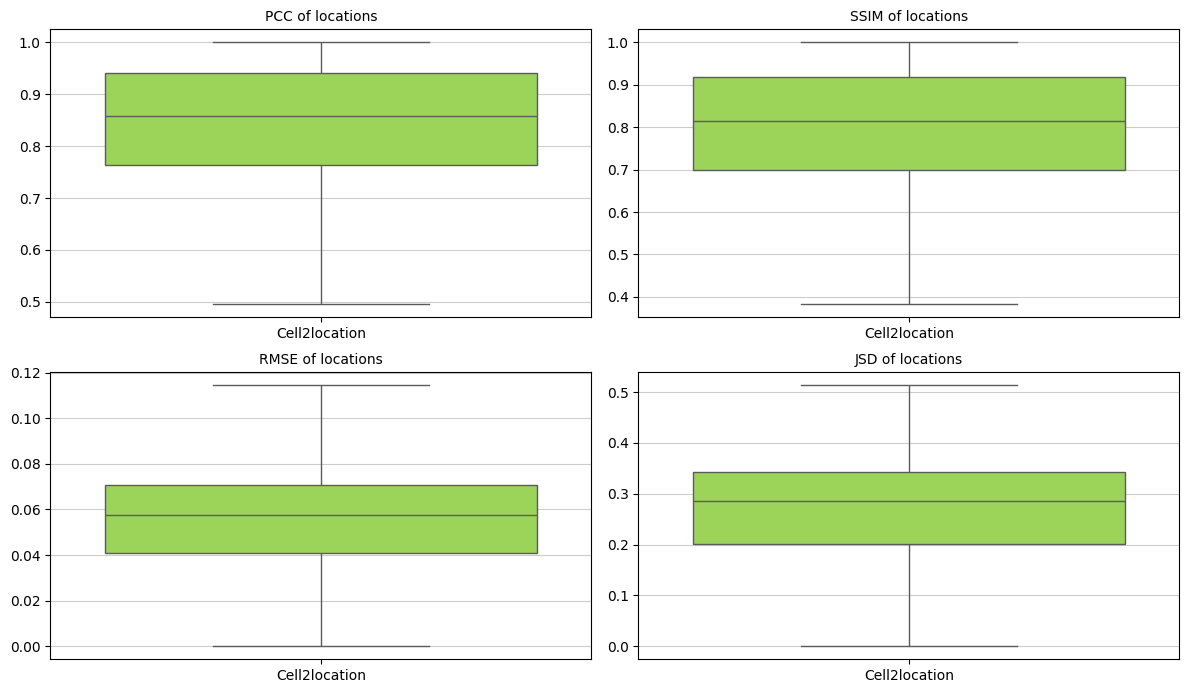

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming starmap_spots_pcc, starmap_spots_ssim, starmap_spots_rmse, starmap_spots_jsd are DataFrame objects

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))

order = ['Cell2location']
colors = ["#9de846"]

sns.boxplot(data=starmap_spots_pcc, order=order, palette=colors, ax=axes[0, 0], orient='v', showfliers=False, showmeans=False)
axes[0, 0].set_title('PCC of locations')

sns.boxplot(data=starmap_spots_ssim, order=order, palette=colors, ax=axes[0, 1], orient='v', showfliers=False, showmeans=False)
axes[0, 1].set_title('SSIM of locations')

sns.boxplot(data=starmap_spots_rmse, order=order, palette=colors, ax=axes[1, 0], orient='v', showfliers=False, showmeans=False)
axes[1, 0].set_title('RMSE of locations')

sns.boxplot(data=starmap_spots_jsd, order=order, palette=colors, ax=axes[1, 1], orient='v', showfliers=False, showmeans=False)
axes[1, 1].set_title('JSD of locations')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# sns.boxplot(data=starmap_clusters_pcc,order=order,palette=colors,ax=axes[1,0],orient='h', showfliers = False,showmeans=True)
# axes[1,0].set_title('PCC of clusters')
# sns.boxplot(data=starmap_clusters_ssim,order=order,palette=colors,ax=axes[1,1],orient='h', showfliers = False,showmeans=True)
# axes[1,1].set_title('SSIM of clusters')
# sns.boxplot(data=starmap_clusters_rmse,order=order,palette=colors,ax=axes[1,2],orient='h', showfliers = False,showmeans=True)
# axes[1,2].set_title('RMSE of clusters')
# sns.boxplot(data=starmap_clusters_jsd,order=order,palette=colors,ax=axes[1,3],orient='h', showfliers = False,showmeans=True)
# axes[1,3].set_title('JSD of clusters')
# plt.savefig(os.path.join('FigureData/Figure4/Dataset10_STARmap/Result_STARmap','starmap_all_metrics.pdf'),dpi=300,bbox_inches='tight')
#plt.show()
# plt.close()